# Experiment 1.2 - Xgboost with hyperparameter tuning

Use a method to tune hyperparameters for the xgboost model.

https://www.mikulskibartosz.name/xgboost-hyperparameter-tuning-in-python-using-grid-search/

https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import load_data function from helper file 
%load_ext autoreload
%autoreload 2

# fix system path
import sys
sys.path.append("/home/jovyan/work")

In [3]:
from src.features.helper_functions import load_sets

X_train, y_train, X_val, y_val, X_test = load_sets()

In [4]:
print(X_train)
print(X_val)

[[ 7.416e+03  6.400e+01  1.390e+01 ...  4.000e-01  1.000e-01  7.000e-01]
 [ 4.919e+03  8.100e+01  2.080e+01 ...  6.000e-01  1.000e-01  1.300e+00]
 [ 7.672e+03  5.000e+01  5.600e+00 ...  4.000e-01 -3.000e-01  3.000e-01]
 ...
 [ 5.832e+03  5.500e+01  1.560e+01 ...  5.000e-01  3.000e-01  8.000e-01]
 [ 5.163e+03  9.100e+01  4.790e+01 ...  9.000e-01  6.000e-01  1.600e+00]
 [ 8.346e+03  6.700e+01  2.640e+01 ...  6.000e-01  2.400e+00  1.000e+00]]
[[9.0960e+03 4.2000e+01 7.4000e+00 ... 3.0000e-01 0.0000e+00 3.0000e-01]
 [1.1122e+04 5.9000e+01 1.2600e+01 ... 4.0000e-01 2.0000e-01 1.0000e+00]
 [1.1247e+04 7.0000e+01 1.6100e+01 ... 4.0000e-01 4.0000e-01 1.4000e+00]
 ...
 [1.0720e+04 6.7000e+01 2.3800e+01 ... 1.1000e+00 3.0000e-01 1.9000e+00]
 [7.6770e+03 4.4000e+01 2.0200e+01 ... 7.0000e-01 4.0000e-01 1.3000e+00]
 [1.1406e+04 7.9000e+01 2.8500e+01 ... 1.2000e+00 1.0000e-01 3.0000e+00]]


## Create grid search parameters

In [5]:
# pip install xgboost -- run this if xgboost doesn't load
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [6]:
# instatiate xgboost 
model = XGBClassifier(seed=42)

In [7]:
# define parameters to try
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [8]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring = 'roc_auc', # use roc_auc to score
    n_jobs = -1, # use all available processors
    cv = 10, # no of folds for cross validation
    verbose=3 # display all info as the model trains
)

In [9]:
# train
grid_result = grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed: 56.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 98.7min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 132.2min finished
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [10]:
# from sklearn.model_selection import StratifiedKFold
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

# summarise results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.699132 using {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 140}


## Train the model using best parameters

In [12]:
# Train using best parameters
model = XGBClassifier(max_depth = 2, n_estimators = 140, learning_rate = 0.05)

In [13]:
model_best_params = model.fit(X_train, y_train)

[01:53:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [14]:
from src.features.helper_functions import save_model

In [16]:
save_model(model_best_params, 'rex_xgb_gridsearch')

Model saved


## Make predictions using validation set

In [17]:
# predict class
y_train_preds = model_best_params.predict(X_train)
y_val_preds = model_best_params.predict(X_val)

In [18]:
# predict proabilities
y_train_preds_prob = model_best_params.predict_proba(X_train)
y_val_preds_prob = model_best_params.predict_proba(X_val)

In [19]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [20]:
print(mse(y_train, y_train_preds, squared=False))
print(mae(y_train, y_train_preds))

print(mse(y_val, y_val_preds, squared=False))
print(mae(y_val, y_val_preds))

0.4052391269361832
0.16421875
0.40543186850567137
0.164375


In [21]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, y_val_preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.56%


In [22]:
from sklearn.metrics import roc_auc_score ,recall_score, precision_score

In [23]:
precision=precision_score(y_val, y_val_preds)
recall=recall_score(y_val, y_val_preds)
roc=roc_auc_score(y_val, y_val_preds)
print("Precision: %.2f%% " % (precision *100))
print("Recall: %.2f%% " % (recall * 100))
print("AUC: %.2f%% " % (roc *100))

Precision: 84.09% 
Recall: 99.18% 
AUC: 50.56% 


In [24]:
roc_auc_score(y_train, y_train_preds_prob[:,1])

0.7322318537150594

In [25]:
roc_auc_score(y_val, y_val_preds_prob[:,1])

0.7025707588852415

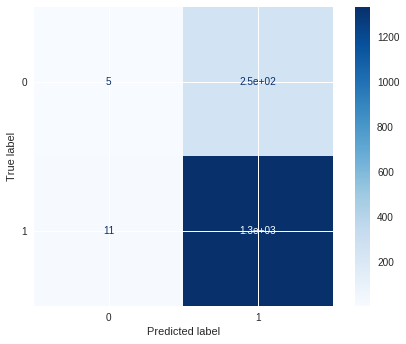

In [62]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model_best_params, X_val, y_val, cmap=plt.cm.Blues)  
plt.show() 

About 250 are being falsely classed as 1, whereas only 11 are being wrongly classed as 0. This may be due to the imbalance majority classs 1, overpowering the 0's. 

Plot roc curve using code from here https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/ 

In [26]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr, tpr, thresh = roc_curve(y_val, y_val_preds_prob[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_val))]
p_fpr, p_tpr, _ = roc_curve(y_val, random_probs, pos_label=1)

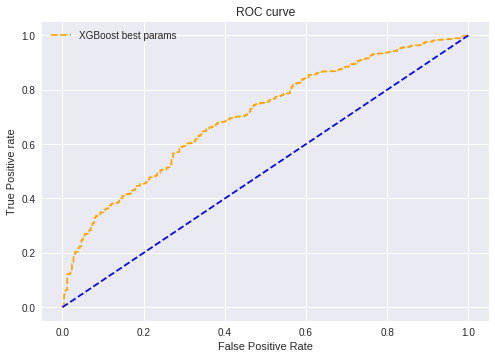

In [27]:
# use matplotlib to plot ROC curve
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBoost best params')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('../src/visualisation/Rez XGBoost best params',dpi=300)
plt.show()

Slight improvement over base model, the AUC is higher at 0.702, but that is still under the current best score on the leaderboard.

More paramaters can be tuned, try a few more before moving onto a different model e.g. SVM.

## Make predictions with test set for Kaggle submission

In [28]:
y_test_preds = model_best_params.predict(X_test)
y_test_preds_prob = model_best_params.predict_proba(X_test)

In [29]:
print(y_test_preds)
print(y_test_preds_prob)

[1 1 1 ... 1 1 1]
[[0.18422568 0.8157743 ]
 [0.18015075 0.81984925]
 [0.06611437 0.93388563]
 ...
 [0.23977691 0.7602231 ]
 [0.06366652 0.9363335 ]
 [0.1832071  0.8167929 ]]


In [31]:
unique_elements, counts_elements = np.unique(y_test_preds, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1]
 [  26 3773]]


In [32]:
# convert X_test back to df
df_test = pd.DataFrame(X_test)
print(df_test)

           0     1     2     3    4     5     6    7    8     9   10   11  \
0        0.0  56.0   9.1   4.0  1.6   3.7  43.7  0.1  0.3   7.3  0.7  1.2   
1        1.0  43.0  19.3  10.1  3.7   8.1  46.0  0.6  1.7  35.1  1.8  2.5   
2        2.0  82.0  33.9  11.3  4.9  10.6  45.6  0.5  1.9  44.8  1.8  2.7   
3        3.0  86.0  44.7  18.8  6.8  15.9  42.9  0.5  1.8  13.5  4.5  6.3   
4        4.0  58.0  12.3   4.7  1.6   4.0  40.0  0.5  1.7  38.7  1.1  1.3   
...      ...   ...   ...   ...  ...   ...   ...  ...  ...   ...  ...  ...   
3794  3794.0  84.0  21.2   8.7  3.4   6.7  50.2  0.0  0.0  -4.5  1.7  2.5   
3795  3795.0  49.0  16.3   6.4  2.9   6.6  44.4 -0.1 -0.4  19.8  1.0  1.9   
3796  3796.0  53.0   9.9   2.1  0.8   1.8  43.1 -0.4 -0.6   1.9  0.6  1.0   
3797  3797.0  89.0  38.3  14.5  5.4  11.8  45.2  0.5  1.2  24.7  2.5  2.9   
3798  3798.0  55.0  12.0   3.0  1.1   2.5  42.3  0.1  0.6  11.7  0.9  1.1   

        12   13   14   15   16   17   18   19  
0     63.4  1.2  0.8  1.7  

In [42]:
# output predictions
id_col = df_test.iloc[:,[0]]

In [43]:
print(id_col)

           0
0        0.0
1        1.0
2        2.0
3        3.0
4        4.0
...      ...
3794  3794.0
3795  3795.0
3796  3796.0
3797  3797.0
3798  3798.0

[3799 rows x 1 columns]


In [48]:
id_col.rename(columns = {0:'Id'}, inplace = True)

In [53]:
print(id_col.columns)
print(id_col.info())

Index(['Id'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3799 entries, 0 to 3798
Data columns (total 1 columns):
Id    3799 non-null float64
dtypes: float64(1)
memory usage: 29.8 KB
None


In [58]:
# need to change Id to int
id_col = id_col.Id.astype(int)

In [50]:
probabilities = pd.DataFrame(y_test_preds_prob[:,1], columns = ['TARGET_5Yrs'])
print(probabilities)

      TARGET_5Yrs
0        0.815774
1        0.819849
2        0.933886
3        0.958387
4        0.798322
...           ...
3794     0.945737
3795     0.815885
3796     0.760223
3797     0.936333
3798     0.816793

[3799 rows x 1 columns]


In [59]:
# concat columns
output = pd.concat([id_col,probabilities], axis=1)

#df_output = pd.DataFrame(output_list, columns = ['Id','TARGET_5Yrs'])
print(output.head())

   Id  TARGET_5Yrs
0   0     0.815774
1   1     0.819849
2   2     0.933886
3   3     0.958387
4   4     0.798322


In [60]:
# save to csv
output.to_csv('../data/processed/output_xgboost_best_params_wk1.csv',index=False)

# Kaggle AUC = 0.70615